In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/TF2/Mask_Detection'

/content/drive/MyDrive/TF2/Mask_Detection


In [4]:
ls

drive/  sample_data/


New Detection

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [6]:
mask = list(paths.list_images('dataset/with_mask'))
noMask = list(paths.list_images('dataset/without_mask'))
data = []
labels = []

In [7]:
for mask in mask:
  label = 'mask'

  image = load_img(mask, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [9]:
print(len(labels), " ", len(data))

2160   2160


In [10]:
for noMask in noMask:
  label = 'noMask'

  image = load_img(noMask, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

In [11]:
print(len(labels), " ", len(data))

4090   4090


In [12]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [15]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [17]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [20]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [23]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
102/102 [==============================] - 58s 381ms/step - loss: 0.5384 - accuracy: 0.7624 - val_loss: 0.1459 - val_accuracy: 0.9719
Epoch 2/20
102/102 [==============================] - 38s 368ms/step - loss: 0.1591 - accuracy: 0.9571 - val_loss: 0.0849 - val_accuracy: 0.9768
Epoch 3/20
102/102 [==============================] - 37s 365ms/step - loss: 0.1039 - accuracy: 0.9728 - val_loss: 0.0697 - val_accuracy: 0.9768
Epoch 4/20
102/102 [==============================] - 37s 366ms/step - loss: 0.0838 - accuracy: 0.9766 - val_loss: 0.0615 - val_accuracy: 0.9780
Epoch 5/20
102/102 [==============================] - 37s 367ms/step - loss: 0.0667 - accuracy: 0.9815 - val_loss: 0.0544 - val_accuracy: 0.9804
Epoch 6/20
102/102 [==============================] - 38s 368ms/step - loss: 0.0566 - accuracy: 0.9840 - val_loss: 0.0534 - val_accuracy: 0.9792
Epoch 7/20
102/102 [==============================] - 38s 368ms/step - loss: 0.0525 - accuracy: 0.9815 - v

In [35]:
model.save('/content/drive/MyDrive/TF2/Mask_Detection/saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TF2/Mask_Detection/saved_model/assets


In [36]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

        mask       0.98      1.00      0.99       432
      noMask       1.00      0.98      0.99       386

    accuracy                           0.99       818
   macro avg       0.99      0.99      0.99       818
weighted avg       0.99      0.99      0.99       818



KeyError: ignored

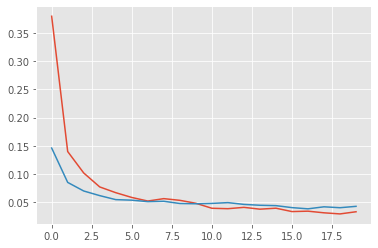

In [37]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

Old Detection

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
#Python code used to parse XML files and put into a table.

import os
import xml.etree.ElementTree as et
import re
import pandas as pd

dic = {"image": [],"Dimensions": []}
for i in range(1,116):
	dic[f'Object {i}']=[]
print("Generating data in CSV format....")

for file in os.listdir("annotations"):
    row = []
    xml = et.parse("annotations/"+file) 
    root = xml.getroot()
    img = root[1].text
    row.append(img)
    h,w = root[2][0].text,root[2][1].text
    row.append([h,w])

    for i in range(4,len(root)):
        temp = []
        temp.append(root[i][0].text)
        for point in root[i][5]:
            temp.append(point.text)
        row.append(temp)
    for i in range(len(row),119):
        row.append(0)
    for i,each in enumerate(dic):
        dic[each].append(row[i])
df = pd.DataFrame(dic)

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import os
import cv2
import random as rand

image_directories = sorted(glob.glob(os.path.join("images","*.png")))
j=0
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

print("Extracting each data into respective label folders....")
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            if((info[3]-info[1])>40 and (info[4]-info[2])>40):
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)
                    if(label=="mask_weared_incorrect"):
                        data.append(face)
                        labels.append(label)

                except:
                    pass


                
print("Done!")

Extracting each data into respective label folders....
Done!


In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 1

In [ ]:
len(data)

367

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.3, stratify=labels, random_state=42)

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
256/256 [==============================] - 11s 33ms/step - loss: 0.9162 - accuracy: 0.6112 - val_loss: 0.4192 - val_accuracy: 0.8649
Epoch 2/50
256/256 [==============================] - 7s 26ms/step - loss: 0.4459 - accuracy: 0.8671 - val_loss: 0.3390 - val_accuracy: 0.8829
Epoch 3/50
256/256 [==============================] - 7s 26ms/step - loss: 0.4050 - accuracy: 0.8902 - val_loss: 0.2928 - val_accuracy: 0.9189
Epoch 4/50
256/256 [==============================] - 7s 26ms/step - loss: 0.3152 - accuracy: 0.9092 - val_loss: 0.2790 - val_accuracy: 0.9009
Epoch 5/50
256/256 [==============================] - 7s 26ms/step - loss: 0.3762 - accuracy: 0.8708 - val_loss: 0.2455 - val_accuracy: 0.9099
Epoch 6/50
256/256 [==============================] - 7s 26ms/step - loss: 0.3766 - accuracy: 0.8651 - val_loss: 0.2300 - val_accuracy: 0.9369
Epoch 7/50
256/256 [==============================] - 7s 26ms/step - loss: 0.3990 - accurac

In [ ]:
import tempfile
import tensorflow as tf
from tensorflow import keras

MODEL_DIR = tempfile.gettempdir()
ver = 1
export_path = os.path.join(MODEL_DIR, str(ver))
print ('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
        model,
        export_path,
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None
    )

print('\nSaved model:')

export_path = C:\Users\Aaron\AppData\Local\Temp\1

INFO:tensorflow:Assets written to: C:\Users\Aaron\AppData\Local\Temp\1\assets

Saved model:


[INFO] evaluating network...
                       precision    recall  f1-score   support

mask_weared_incorrect       0.70      1.00      0.82         7
            with_mask       0.98      0.97      0.97        92
         without_mask       1.00      0.83      0.91        12

             accuracy                           0.95       111
            macro avg       0.89      0.93      0.90       111
         weighted avg       0.96      0.95      0.96       111

[INFO] saving mask detector model...


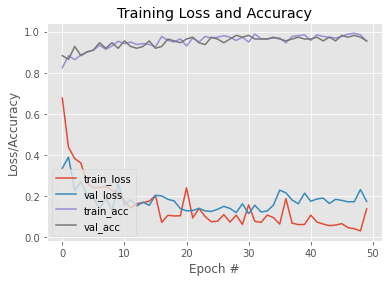

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...

OSError: SavedModel file does not exist at: /saved_model/{saved_model.pbtxt|saved_model.pb}